In [19]:
import pandas as pd

In [20]:
df = pd.read_csv("/content/GlobalWeatherRepository[1].csv")

In [21]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57880 entries, 0 to 57879
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       57880 non-null  object 
 1   location_name                 57880 non-null  object 
 2   latitude                      57880 non-null  float64
 3   longitude                     57880 non-null  float64
 4   timezone                      57880 non-null  object 
 5   last_updated_epoch            57880 non-null  int64  
 6   last_updated                  57880 non-null  object 
 7   temperature_celsius           57880 non-null  float64
 8   temperature_fahrenheit        57880 non-null  float64
 9   condition_text                57880 non-null  object 
 10  wind_mph                      57880 non-null  float64
 11  wind_kph                      57880 non-null  float64
 12  wind_degree                   57880 non-null  int64  
 13  w

In [22]:
print(df.head())

       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  Partly cloudy

In [23]:
df['last_updated'] = pd.to_datetime(df['last_updated'])

In [24]:
df.fillna({
    'temperature_celsius': df['temperature_celsius'].median(),
    'air_quality_PM2.5': df['air_quality_PM2.5'].median(),
    'air_quality_PM10': df['air_quality_PM10'].median(),
    'condition_text': df['condition_text'].mode()[0]
}, inplace=True)

In [25]:
Q1 = df[['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']].quantile(0.25)
Q3 = df[['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']] < (Q1 - 1.5 * IQR)) |
          (df[['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']] = scaler.fit_transform(
    df[['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']]
)


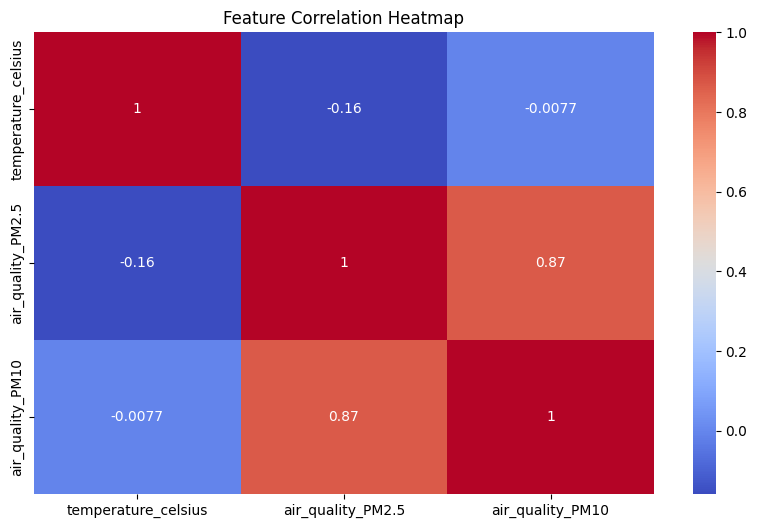

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(df[['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


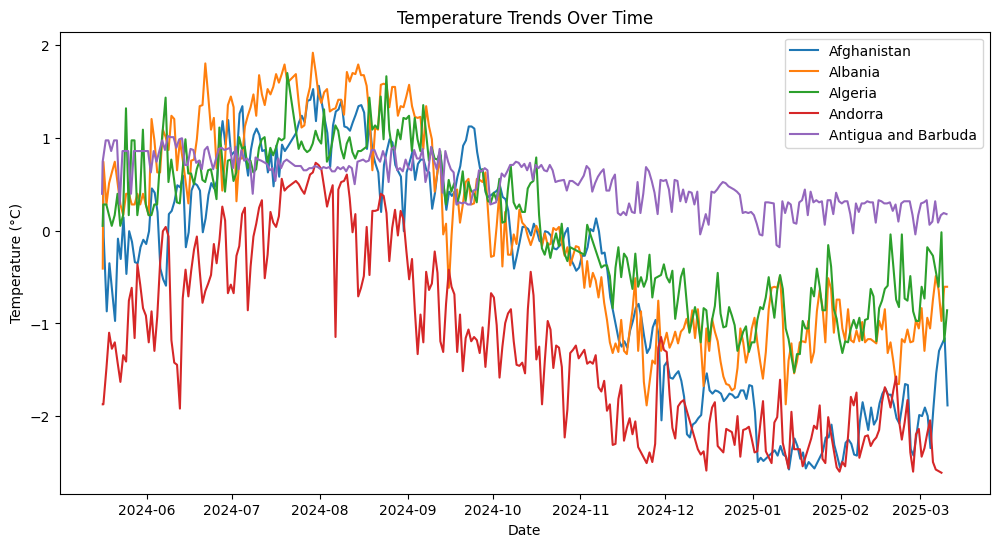

In [28]:
plt.figure(figsize=(12, 6))
for country in df['country'].unique()[:5]:  # Sample 5 countries
    country_df = df[df['country'] == country]
    plt.plot(country_df['last_updated'], country_df['temperature_celsius'], label=country)

plt.legend()
plt.title("Temperature Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40481 (\N{CJK UNIFIED IDEOGRAPH-9E21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


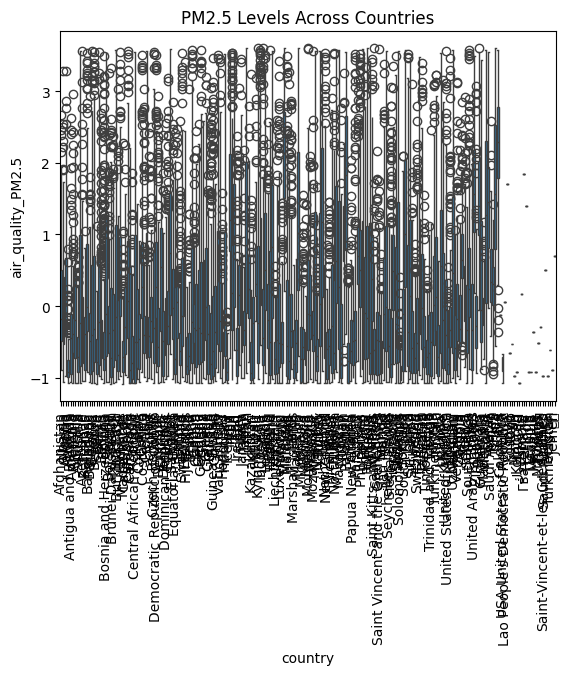

In [29]:
sns.boxplot(x='country', y='air_quality_PM2.5', data=df)
plt.xticks(rotation=90)
plt.title("PM2.5 Levels Across Countries")
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

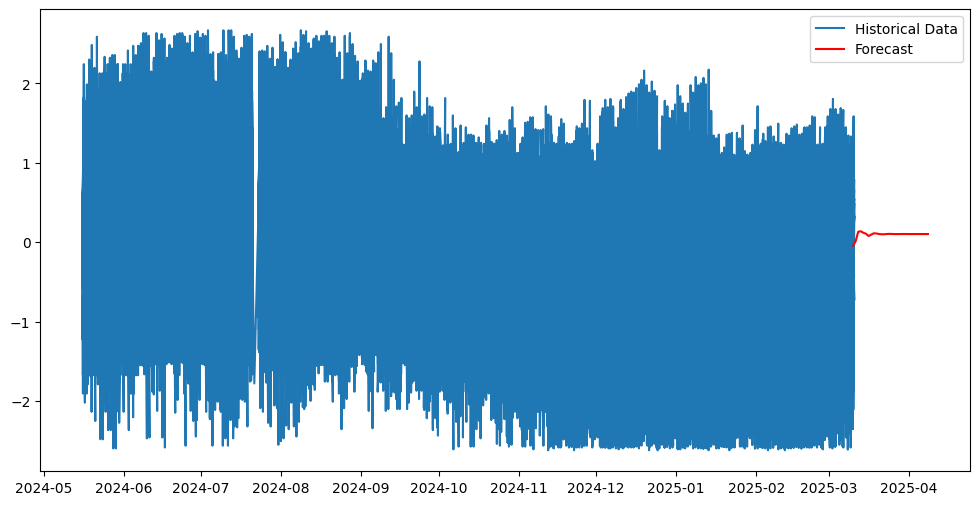

In [30]:
from statsmodels.tsa.arima.model import ARIMA

df.set_index("last_updated", inplace=True)

# Train ARIMA model
model = ARIMA(df['temperature_celsius'], order=(5,1,0))
model_fit = model.fit()

# Forecast future values
forecast = model_fit.forecast(steps=30)  # Predict next 30 days

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df['temperature_celsius'], label="Historical Data")
plt.plot(pd.date_range(start=df.index[-1], periods=30, freq='D'), forecast, label="Forecast", color='red')
plt.legend()
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.9105
Epoch 2/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.8727
Epoch 3/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.8614
Epoch 4/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8492
Epoch 5/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.8140
Epoch 6/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7982
Epoch 7/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7881
Epoch 8/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7614
Epoch 9/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7473
Epoch 10/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7232
Epoch 11/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7141
Epoch 12/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7019
Epoch 13/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6915
Epoch 14/50
1558/1558 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6766
Epoch 15/50
1558/1558 ━━━━━━━━━

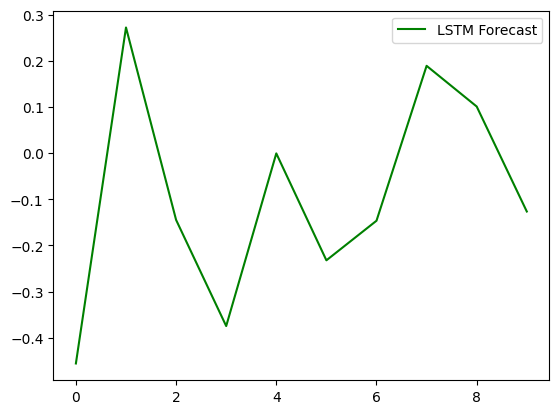

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Prepare data
def prepare_lstm_data(series, window_size=10):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

X_train, y_train = prepare_lstm_data(df['temperature_celsius'].values)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, verbose=1)

# Predict future values
forecast_lstm = model.predict(X_train[-10:])

# Plot forecast
plt.plot(forecast_lstm, label="LSTM Forecast", color='green')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40481 (\N{CJK UNIFIED IDEOGRAPH-9E21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


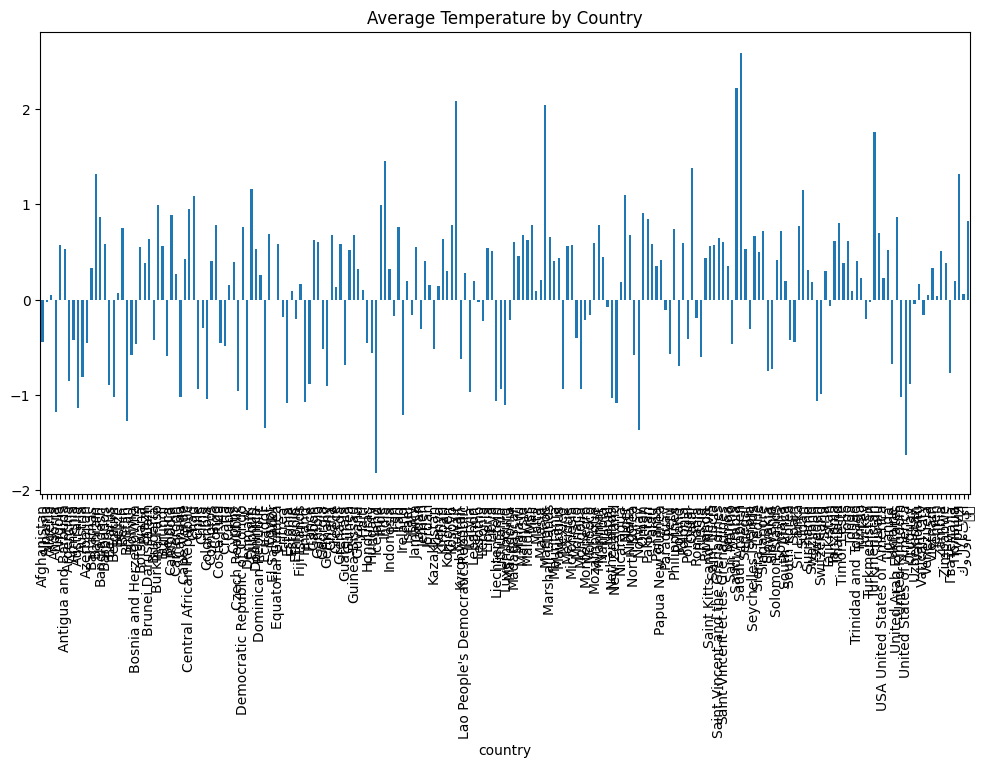

In [32]:
df.groupby("country")["temperature_celsius"].mean().plot(kind='bar', figsize=(12,6))
plt.title("Average Temperature by Country")
plt.show()


In [37]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

# Create a base map centered at an approximate global position
m = folium.Map(location=[20, 0], zoom_start=2)

# Add heatmap data (latitude, longitude, and temperature)
heat_data = list(zip(df['latitude'], df['longitude'], df['temperature_celsius']))

# Add heatmap layer
HeatMap(heat_data).add_to(m)

# Display map
display(m)


